In [1]:
import os
import random
from PIL import Image
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
import random
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
device = 'mps' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import time as time
print(device)

mps


In [2]:
import cv2
import os
from pathlib import Path

def save_detect_image(folder_path, padding_factor=0.1):
    if folder_path[-1] == '/':
        save_folder_path = folder_path[:-1] + '_face'
    else:
        save_folder_path = folder_path + '_face'

    Path(save_folder_path).mkdir(parents=True, exist_ok=True)

    cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    face_cascade = cv2.CascadeClassifier(cascade_path)

    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = cv2.imread(image_path)
        if image is None:  
            continue
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            padding_w = int(w * padding_factor)
            padding_h = int(h * padding_factor)
            x_pad = max(x - padding_w, 0)
            y_pad = max(y - padding_h, 0)
            w_pad = min(w + 2 * padding_w, image.shape[1] - x_pad)
            h_pad = min(h + 2 * padding_h, image.shape[0] - y_pad)

            face_img_with_padding = image[y_pad:y_pad+h_pad, x_pad:x_pad+w_pad]

            save_path = os.path.join(save_folder_path, filename)
            cv2.imwrite(save_path, face_img_with_padding)

    return save_folder_path


In [3]:
# save_detect_image("./080289-main/chap06/data/dogs-vs-cats/Cat")
# save_detect_image("./080289-main/chap06/data/dogs-vs-cats/Dog")
# save_detect_image("./080289-main/chap06/data/dogs-vs-cats/Cat_v")
# save_detect_image("./080289-main/chap06/data/dogs-vs-cats/Dog_v")

### dataloader 만들기

In [4]:
class CatsDogsSiameseDataset(Dataset):
    def __init__(self, cat_directory, dog_directory, transform=None):
        self.cat_images = [os.path.join(cat_directory, img) for img in os.listdir(cat_directory)]
        self.dog_images = [os.path.join(dog_directory, img) for img in os.listdir(dog_directory)]
        random.shuffle(self.cat_images)
        self.count=0
        if len(self.cat_images) < len(self.dog_images):
            for i in range(0,len(self.dog_images)-len(self.cat_images)):
                if self.count==len(self.cat_images):
                    self.count=0
                self.cat_images.append(self.cat_images[self.count])
                self.count+=1
        elif len(self.cat_images) > len(self.dog_images):
            for i in range(0,len(self.cat_images)-len(self.dog_images)):
                if self.count==len(self.dog_images):
                    self.count=0
                self.dog_images.append(self.dog_images[self.count])
                self.count+=1
        self.transform = transform
        # 고양이는 0, 강아지는 1로 레이블 지정
        self.labels = []
        for i in self.cat_images:
            if 'chan' in i:
                self.labels.append(1)
            else:
                self.labels.append(0)
        self.cat_len=len(self.cat_images)
        self.dog_len=len(self.dog_images)

    def __getitem__(self, index):
        # 첫 번째 이미지 선택
        img1_path = self.dog_images[index]
        label = self.labels[index]
        

        img2_path = self.cat_images[index]

        img1 = Image.open(img1_path)
        img2 = Image.open(img2_path)

        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, torch.from_numpy(np.array([int(label)], dtype=np.float32))

    def __len__(self):
        return len(self.cat_images)

In [5]:
from torch.utils.data import Sampler
import numpy as np

class CustomSampler(Sampler):
    def __init__(self, data_source, positive_ratio=0.8):
        self.data_source = data_source
        self.positive_ratio = positive_ratio

    def __iter__(self):
        num_samples = len(self.data_source)
        num_positives = int(num_samples * self.positive_ratio)
        num_negatives = num_samples - num_positives
        
        positive_indices = [i for i, label in enumerate(self.data_source.labels) if label == 1]
        negative_indices = [i for i, label in enumerate(self.data_source.labels) if label == 0]
        
        chosen_positives = np.random.choice(positive_indices, num_positives, replace=True)
        chosen_negatives = np.random.choice(negative_indices, num_negatives, replace=False)
        
        all_indices = np.hstack([chosen_positives, chosen_negatives])
        np.random.shuffle(all_indices)
        
        return iter(all_indices.tolist())

    def __len__(self):
        return len(self.data_source)


In [6]:
# 데이터 전처리 정의
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor(),
])

train_dataset = CatsDogsSiameseDataset(cat_directory=r'./Cat_face', dog_directory=r'./Dog_face', transform=transform)
train_sampler = CustomSampler(train_dataset, positive_ratio=0.4)

train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)

val_dataset = CatsDogsSiameseDataset(cat_directory=r'./Cat_v_face', dog_directory=r'./Dog_v_face', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}


In [7]:
# # 평균과 표준편차 구하기
# import numpy as np

# meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ ,_ in dataset]
# stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_,_ in dataset]

# meanR = np.mean([m[0] for m in meanRGB])
# meanG = np.mean([m[1] for m in meanRGB])
# meanB = np.mean([m[2] for m in meanRGB])

# stdR = np.mean([s[0] for s in stdRGB])
# stdG = np.mean([s[1] for s in stdRGB])
# stdB = np.mean([s[2] for s in stdRGB])

# print(meanR, meanG, meanB)
# print(stdR, stdG, stdB)

In [8]:
# # 평균과 표준편차 구하기
# import numpy as np
# meanRGB = [np.mean(x.numpy(), axis=(1,2)) for _,x ,_ in dataset]
# stdRGB = [np.std(x.numpy(), axis=(1,2)) for _,x,_ in dataset]

# meanR = np.mean([m[0] for m in meanRGB])
# meanG = np.mean([m[1] for m in meanRGB])
# meanB = np.mean([m[2] for m in meanRGB])

# stdR = np.mean([s[0] for s in stdRGB])
# stdG = np.mean([s[1] for s in stdRGB])
# stdB = np.mean([s[2] for s in stdRGB])

# print(meanR, meanG, meanB)
# print(stdR, stdG, stdB)

### 확인용

In [9]:
"""from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# 데이터로더에서 몇 개의 이미지 쌍을 시각적으로 확인하는 함수
def visualize_image_pairs(dataloader, num_pairs=20):
    fig, axes = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, num_pairs * 5))
    
    # 데이터로더에서 이미지 쌍을 가져옴
    for i, (img1, img2, label) in enumerate(dataloader):
        if i >= num_pairs:
            break
        
        # 첫 번째 이미지 쌍을 왼쪽 열에 표시
        ax = axes[i, 0]
        ax.imshow(img1[0].permute(1, 2, 0))
        ax.set_title(f'Pair {i+1} - Image 1')
        ax.axis('off')
        
        # 두 번째 이미지 쌍을 오른쪽 열에 표시
        ax = axes[i, 1]
        ax.imshow(img2[0].permute(1, 2, 0))
        ax.set_title(f'Pair {i+1} - Image 2 {"(Same)" if label[0] == 1 else "(Different)"}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_image_pairs(dataloader, num_pairs=5)
"""

'from torchvision.utils import make_grid\nimport matplotlib.pyplot as plt\n\n# 데이터로더에서 몇 개의 이미지 쌍을 시각적으로 확인하는 함수\ndef visualize_image_pairs(dataloader, num_pairs=20):\n    fig, axes = plt.subplots(nrows=num_pairs, ncols=2, figsize=(10, num_pairs * 5))\n    \n    # 데이터로더에서 이미지 쌍을 가져옴\n    for i, (img1, img2, label) in enumerate(dataloader):\n        if i >= num_pairs:\n            break\n        \n        # 첫 번째 이미지 쌍을 왼쪽 열에 표시\n        ax = axes[i, 0]\n        ax.imshow(img1[0].permute(1, 2, 0))\n        ax.set_title(f\'Pair {i+1} - Image 1\')\n        ax.axis(\'off\')\n        \n        # 두 번째 이미지 쌍을 오른쪽 열에 표시\n        ax = axes[i, 1]\n        ax.imshow(img2[0].permute(1, 2, 0))\n        ax.set_title(f\'Pair {i+1} - Image 2 {"(Same)" if label[0] == 1 else "(Different)"}\')\n        ax.axis(\'off\')\n    \n    plt.tight_layout()\n    plt.show()\n\nvisualize_image_pairs(dataloader, num_pairs=5)\n'

In [10]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [11]:
from torchvision.models import mobilenet_v3_large
from facenet_pytorch import InceptionResnetV1
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.model=mobilenet_v3_large(pretrained=True)
        #self.model=InceptionResnetV1(pretrained='vggface2')

        self.fc = nn.Sequential(
            nn.Linear(960, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
        )
            
        self.model.classifier=self.fc
    def forward(self, input1, input2):
        output1 = self.model(input1)
        output2 = self.model(input2)
        return output1, output2

In [12]:
model=SiameseNetwork().to(device)
criterion=ContrastiveLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0005)

/Users/ijimin/miniforge3/envs/ForFace/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ijimin/miniforge3/envs/ForFace/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):    
    since = time.time()
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        TP=0
        TN=0
        FP=0
        FN=0
        pos=[]
        neg=[]
        for phase in ['train', 'val']:            
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            
            for inputs1,inputs2, labels in tqdm(dataloader_dict[phase]):
                inputs1 = inputs1.to(device)
                inputs2=inputs2.to(device)
                labels=labels.to(device)
                optimizer.zero_grad()
                

                with torch.set_grad_enabled(phase == 'train'):#학습 시에만 연산 기록을 추적
                    outputs1,outputs2 = model(inputs1,inputs2)

                    loss = criterion(outputs1,outputs2, labels)

                    epoch_loss += loss.item() * inputs1.size(0)
                
                for i in range(32):
                     if phase=='val':
                        try:
                            concatenated=torch.stack((inputs1[i].to('cpu'),inputs2[i].to('cpu')),dim=0)
                        except:
                            break
                        distance=F.pairwise_distance(outputs1[i],outputs2[i])
                        if(torch.tensor([1.], device='mps')==labels[i]):
                            if(distance>0.6):
                                FN+=1
                            else:
                                TP+=1
                            pos.append(distance.cpu().tolist())
                        else:
                            if(distance>0.6):
                                TN+=1
                            else:
                                FP+=1
                            neg.append(distance.cpu().tolist())

                for i in range(16):
                     if phase=='val':
                        if epoch==num_epoch-1:
                            try:
                                concatenated=torch.stack((inputs1[i].to('cpu'),inputs2[i].to('cpu')),dim=0)
                            except:
                                break
                            distance=F.pairwise_distance(outputs1[i],outputs2[i])
                            img = torchvision.utils.make_grid(concatenated).permute(1, 2, 0) # CHW to HWC
                            plt.figure(figsize=(10, 5)) # 이미지 크기 설정
                            plt.imshow(img)
                            plt.text(10, -10, 'Dissimilarity: {:.2f}'.format(distance.item()), color='red')
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            if(phase=='val'):
                try:
                    print("민감도:%.2f 특이도:%.2f PPV:%.2f NPV:%.2f \n pos_m:%.2f neg_m:%.2f"%(TP/(TP+FN),TN/(FP+TN),TP/(TP+FP),TN/(TN+FN),sum(pos)/len(pos),sum(neg)/len(neg)))
                except:
                    print("TP:%d FP:%d FN:%d TN:%d"%(TP,FP,FN,TN))
                
                print("accuracy:%.2f"%((TP+TN)/(TP+TN+FP+FN)))
                print("1종오류:%d"%(FP))
                plt.scatter(pos,[0]*len(pos))
                plt.scatter(neg,[0]*len(neg))
                plt.show()
                torch.save(model,'check%d.pt'%(epoch+1))
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    return model

In [14]:
#if epoch==num_epoch-1:
#                   if phase=='val':
#                       distance=F.pairwise_distance(outputs1[i],outputs2[i])
#                       img = torchvision.utils.make_grid(concatenated).permute(1, 2, 0) # CHW to HWC
#                       plt.figure(figsize=(10, 5)) # 이미지 크기 설정
#                       plt.imshow(img)
#                       plt.text(10, -10, 'Dissimilarity: {:.2f}'.format(distance.item()), color='red')

Epoch 1/30
--------------------


/var/folders/fx/ngvhqygx7vxbdk_cgfnxnz880000gn/T/ipykernel_17437/2059347125.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs1,inputs2, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.4205


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.9827
민감도:1.00 특이도:0.78 PPV:0.25 NPV:1.00 
 pos_m:0.29 neg_m:1.10
accuracy:0.79
1종오류:96


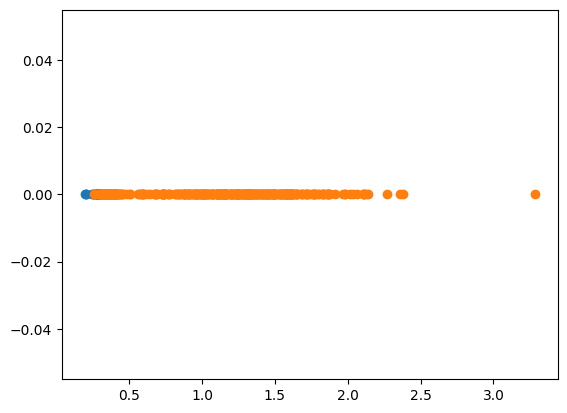

Epoch 2/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0421


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.2391
민감도:1.00 특이도:1.00 PPV:0.94 NPV:1.00 
 pos_m:0.25 neg_m:2.34
accuracy:1.00
1종오류:2


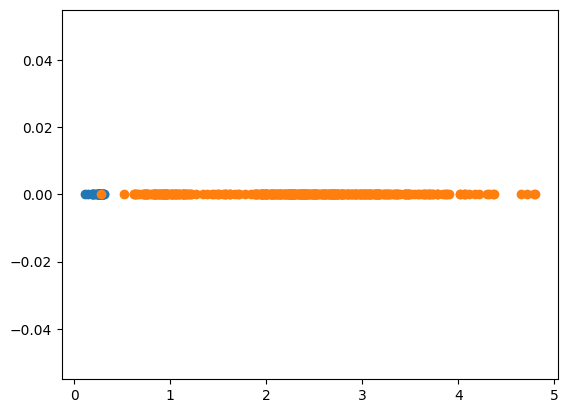

Epoch 3/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0062


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.1473
민감도:1.00 특이도:0.99 PPV:0.86 NPV:1.00 
 pos_m:0.21 neg_m:2.41
accuracy:0.99
1종오류:5


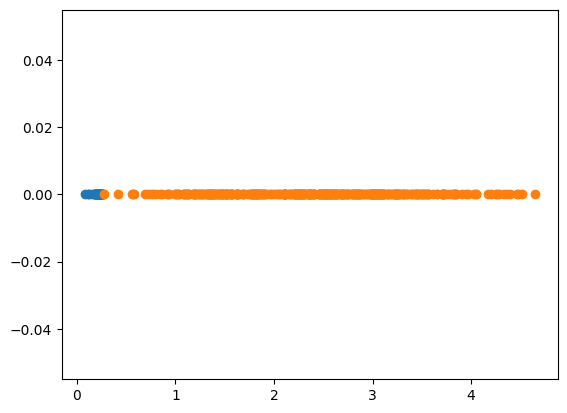

Epoch 4/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0028


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0809
민감도:1.00 특이도:0.99 PPV:0.89 NPV:1.00 
 pos_m:0.18 neg_m:2.61
accuracy:0.99
1종오류:4


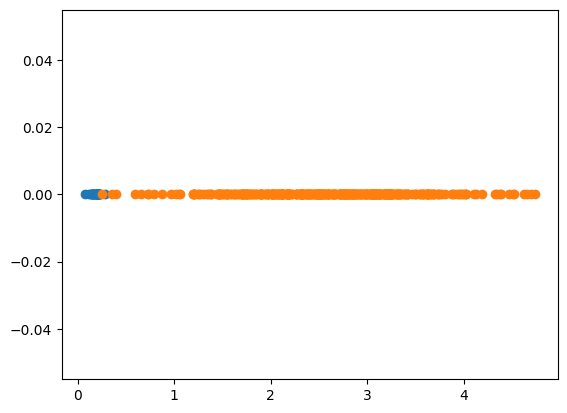

Epoch 5/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0019


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0308
민감도:1.00 특이도:1.00 PPV:0.97 NPV:1.00 
 pos_m:0.17 neg_m:3.02
accuracy:1.00
1종오류:1


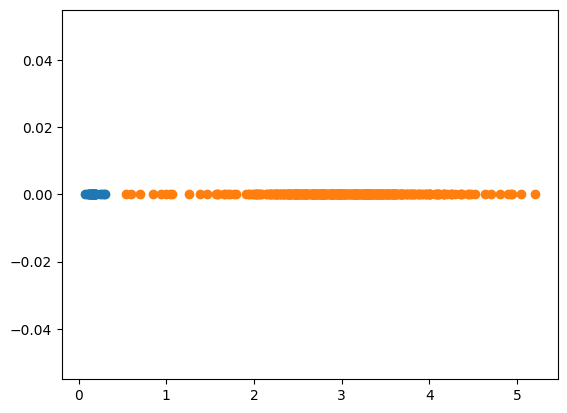

Epoch 6/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0019


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0117
민감도:1.00 특이도:1.00 PPV:0.97 NPV:1.00 
 pos_m:0.17 neg_m:3.26
accuracy:1.00
1종오류:1


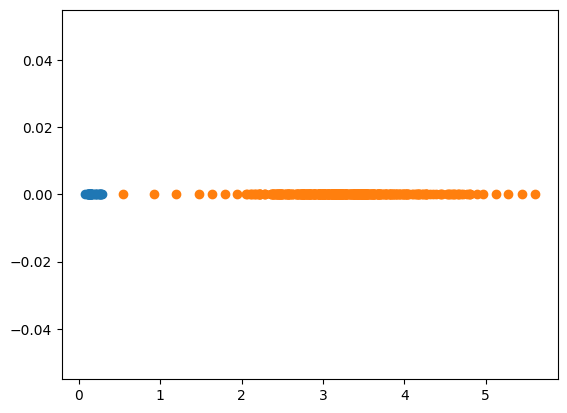

Epoch 7/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0014


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0091
민감도:0.97 특이도:1.00 PPV:1.00 NPV:1.00 
 pos_m:0.23 neg_m:3.36
accuracy:1.00
1종오류:0


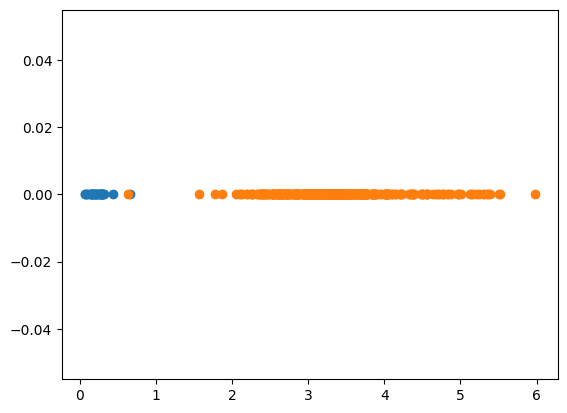

Epoch 8/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0013


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0086
민감도:0.97 특이도:1.00 PPV:1.00 NPV:1.00 
 pos_m:0.27 neg_m:3.47
accuracy:1.00
1종오류:0


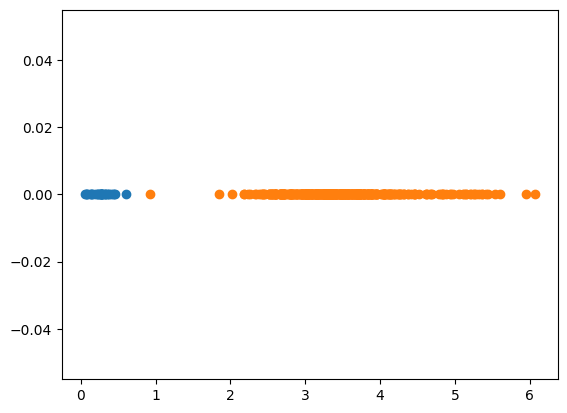

Epoch 9/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0009


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0082
민감도:0.97 특이도:1.00 PPV:1.00 NPV:1.00 
 pos_m:0.29 neg_m:3.69
accuracy:1.00
1종오류:0


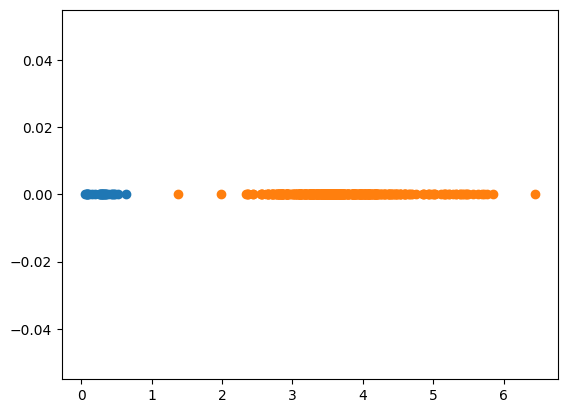

Epoch 10/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

train Loss: 0.0010


  0%|          | 0/15 [00:00<?, ?it/s]

val Loss: 0.0077
민감도:0.97 특이도:1.00 PPV:1.00 NPV:1.00 
 pos_m:0.29 neg_m:3.94
accuracy:1.00
1종오류:0


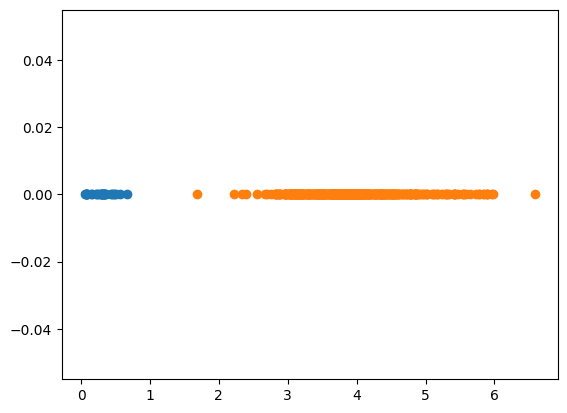

Epoch 11/30
--------------------


  0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
train_model(model=model,dataloader_dict=dataloader_dict,criterion=criterion, optimizer=optimizer, num_epoch=30)
torch.save(model, 'shinchan.pt')